### Data preparation

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import pandas as pd
import numpy as np

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP/train_preprocessed.csv'
train = pd.read_csv(file_path)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP/test_preprocessed.csv'
test = pd.read_csv(file_path)

In [3]:
train.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0000997932d777bf,"['explanation', 'edits', 'made', 'username', '...",0,0,0,0,0,0
1,1,000103f0d9cfb60f,"['aww', 'matches', 'background', 'colour', 'se...",0,0,0,0,0,0
2,2,000113f07ec002fd,"['hey', 'man', 'really', 'trying', 'edit', 'wa...",0,0,0,0,0,0
3,3,0001b41b1c6bb37e,"['make', 'real', 'suggestions', 'improvement',...",0,0,0,0,0,0
4,4,0001d958c54c6e35,"['sir', 'hero', 'chance', 'remember', 'page']",0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# separate features and labels
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


x_train, x_test, y_train, y_test = train_test_split(train.loc[:,'comment_text'], train[labels], train_size=0.8)

## Modeling with Bag of Words

### Vectorization - Bag Of Words

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
# tfdif vectorizer with 1 and 2 ngrams
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), 
                            min_df=2, 
                            max_features=1000)
tfidf_vec.fit(x_train)

TfidfVectorizer(max_features=1000, min_df=2, ngram_range=(1, 2))

In [36]:
# trasform train and test
train_tfidf = tfidf_vec.transform(x_train)
test_tfidf = tfidf_vec.transform(x_test)

In [37]:
# extracted features
print(tfidf_vec.get_feature_names_out()[:10])

['able' 'absolutely' 'abuse' 'accept' 'acceptable' 'accepted' 'access'
 'according' 'account' 'accounts']


### Binary Relevance

In [ ]:
!pip install scikit-multilearn

In [7]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

In [44]:
# evaluation function
def eval_fun_br(x_test, y_test, classifier):
    # make label predictions
    y_labels = np.array(classifier.predict(x_test).todense())
    # make probabilities predictions
    y_pred = classifier.predict_proba(x_test).todense()

    # accuracy score as the average of accuracy for individual labels
    accuracy = np.mean([accuracy_score(y_test.to_numpy(), y_labels) for i in range (6)])

    # auc as the average of auc for individual labels
    auc = np.mean([roc_auc_score(y_test.to_numpy(), y_labels) for i in range (6)])

    # logloss as the average of logloss for individual labels
    logloss = np.mean([log_loss(y_test.to_numpy(), y_labels) for i in range(6)])

    return pd.DataFrame({'Model':'BR-' + type(classifier.classifier).__name__,
                        "Accuracy": np.round(accuracy,3),
                        "AUC": np.round(auc,3) ,
                        "Log loss": np.round(logloss,3)}, index = [0])

**Logistic Regression**

In [39]:
# Logistic Regression
lr_clf = BinaryRelevance(LogisticRegression( solver='liblinear'))
lr_clf.fit(train_tfidf, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='liblinear'),
                require_dense=[True, True])

In [66]:
# evaluation
lr_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=lr_clf)
lr_eval

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.909,0.628,1.136


**Naive Bayes**

In [67]:
nb_clf = BinaryRelevance(MultinomialNB())
nb_clf.fit(train_tfidf, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [68]:
# evaluation
nb_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=nb_clf)
nb_eval

,Model,Accuracy,AUC,Log loss
0,BR-MultinomialNB,0.908,0.605,1.11


In [71]:
# comparison of Binary Relevance Results
BR_results = lr_eval.append(nb_eval).reset_index(drop = True)
BR_results

<ipython-input-71-d2408665a05b>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BR_results = lr_eval.append(nb_eval).reset_index(drop = True)


,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.909,0.628,1.136
1,BR-MultinomialNB,0.908,0.605,1.110


### Classifier Chain 

In [3]:
from sklearn.multioutput import ClassifierChain

In [75]:
# evaluation function
def eval_fun_chain(x_test, y_test, classifier):
    # make label predictions
    y_labels = classifier.predict(x_test)
    # make probabilities predictions
    y_pred = classifier.predict_proba(x_test)

    # accuracy score as the average of accuracy for individual labels
    accuracy = np.mean([accuracy_score(y_test.iloc[:,i], y_labels[:,i]) for i in range (6)])

    # auc as the average of auc for individual labels
    auc = np.mean([roc_auc_score(y_test.iloc[:,i], y_pred[:,i]) for i in range (6)])

    # logloss
    logloss = np.mean([log_loss(y_test.iloc[:,i], y_pred[:,i]) for i in range(6)])

    return pd.DataFrame({'Model':'Chain-' + type(classifier.base_estimator).__name__,
                        "Accuracy": np.round(accuracy,3),
                        "AUC": np.round(auc,3) ,
                        "Log loss": np.round(logloss,3)}, index = [0])

**Logistic Regression**

In [73]:
lr_chain = ClassifierChain(LogisticRegression(solver='liblinear'))
lr_chain.fit(train_tfidf, y_train)

ClassifierChain(base_estimator=LogisticRegression(solver='liblinear'))

In [76]:
lr_chain_eval = eval_fun_chain(test_tfidf, y_test, lr_chain)
lr_chain_eval

,Model,Accuracy,AUC,Log loss
0,Chain-LogisticRegression,0.974,0.902,0.096


**Naive Bayes**

In [77]:
nb_chain = ClassifierChain(MultinomialNB())
nb_chain.fit(train_tfidf, y_train)

ClassifierChain(base_estimator=MultinomialNB())

In [78]:
nb_chain_eval = eval_fun_chain(test_tfidf, y_test, nb_chain)
nb_chain_eval

,Model,Accuracy,AUC,Log loss
0,Chain-MultinomialNB,0.967,0.922,0.128


In [79]:
# comparison of the models
chain_results = lr_chain_eval.append(nb_chain_eval).reset_index(drop = True)
chain_results

<ipython-input-79-308443538600>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chain_results = lr_chain_eval.append(nb_chain_eval).reset_index(drop = True)


,Model,Accuracy,AUC,Log loss
0,Chain-LogisticRegression,0.974,0.902,0.096
1,Chain-MultinomialNB,0.967,0.922,0.128


Again we see that using chain classifier, logistic regression is performing better than naive bayes.

**Comparing Binary Relevance and Chain Classifier**

In [80]:
# Comparing Binary Relevance and Chain Classifier
br_chain_results = BR_results.append(chain_results).reset_index(drop = True)
br_chain_results

<ipython-input-80-93581b54a8ce>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  br_chain_results = BR_results.append(chain_results).reset_index(drop = True)


,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.909,0.628,1.136
1,BR-MultinomialNB,0.908,0.605,1.110
2,Chain-LogisticRegression,0.974,0.902,0.096
3,Chain-MultinomialNB,0.967,0.922,0.128


From the results, we see Logistic Regression with Classifier Chain is performing the best. Chain Classifier works better when there is dependencies between the multilabels. From our correlation plot between the labels, we saw that there was a significant correlation. Thus, here chain classifier is performing better than the binary relevance.  

### Word Embeddings/ Sentence Embeddings


We saw that Binary Relevance with Logistic Regression is performing the best. We applied bag of words to represent the text into vector forms. Word embeddings are getting popular as they can also maintian the word order in the text. There are many ways of getting word embeddings and we can train our own also. But, here we will make use of already trained word2vec model from Google to extract the embeddings.

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence. 


In [9]:
!pip install -q gensim

In [10]:
import gensim
import gensim.downloader as api

In [13]:
# download googles pretrained word2vec model
model = api.load("word2vec-google-news-300")

[=================================================-] 99.6% 1656.7/1662.8MB downloaded


In [15]:
#load the vectors from the model
word_vectors = model

In [32]:
# getting average of word vectors for every word in the text

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing=False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, 
                                                            generate_missing=generate_missing))
    return list(embeddings)

Before creating the word embeddings, we will create a different text processing function than we used for bag of words.  We will remove the step for stemming.

In [36]:
# generate train and test embeddings
train_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=x_train)
test_embeddings = get_word2vec_embeddings(vectors=word_vectors, tokens=x_test)

At the moment we have train and test embeddings as a list of 300 size vector array for each sentence in our data. We will convert them to a matrix format, where each sentence will be represented by a array of 300 dimension.

In [37]:
train_embeddings_matrix = np.array(train_embeddings)
test_embeddings_matrix = np.array(test_embeddings)

print(train_embeddings_matrix.shape,  test_embeddings_matrix.shape)

(127656, 300) (31915, 300)


**Binary Relevance -Logistic Regreesion with word embeddings**

In [42]:
lr_we = BinaryRelevance(LogisticRegression(solver = 'liblinear'))
lr_we.fit(train_embeddings_matrix, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='liblinear'),
                require_dense=[True, True])

In [45]:
# evaluation
lr_we_results = eval_fun_br(x_test=test_embeddings_matrix, y_test=y_test, classifier=lr_we)
lr_we_results

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.898,0.536,0.752


Here the resuls show that the embeddings did not perform any better than the bag of words method. The results are almost the same, we can still consider Binary Relevance with Logistic Regression as the best method, considering its simplicity.

To improve our results we can try modeling with Deep Learning, using frameworks line CNN and LSTM. 


## DEEP LEARNING

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout

### **LSTM**

In [47]:
# tokenizing the text
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<unkown>')

tokenizer.fit_on_texts(x_train)

In [48]:
# Number of unique words found
word_index = tokenizer.word_index
print(f'Number of unique words found: {len(word_index)}')

Number of unique words found: 162326


In [49]:
# transform train and test data to tokens
train_tokens = tokenizer.texts_to_sequences(x_train)
test_tokens = tokenizer.texts_to_sequences(x_test)

After tokenizing the words, we will have to perform padding so that all the text sequene have same length. To determine the length of sequence, we will use the mean length of the text sequences.

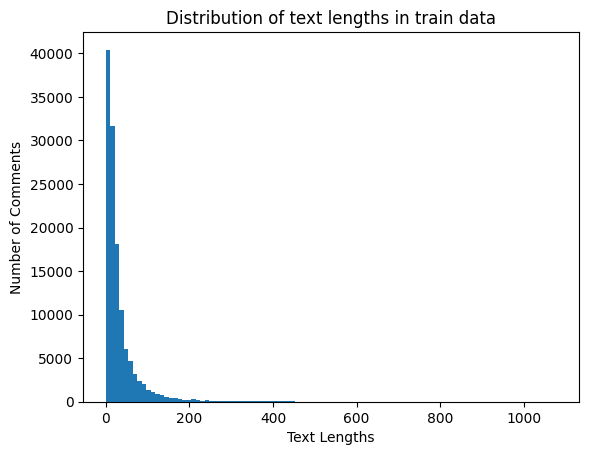

In [51]:
# visualize the distribution of text lenghts
import matplotlib.pyplot as plt

text_lengths = [len(seq) for seq in train_tokens]
plt.hist(text_lengths, bins=100);
plt.title("Distribution of text lengths in train data");
plt.xlabel('Text Lengths');
plt.ylabel("Number of Comments");

In [52]:
print(f'Mean length of text sequences: {np.mean(text_lengths)}')

Mean length of text sequences: 34.274119508679576


We see majority of coments have text lenghts of around 200. So, we will pad our texts to the length of 200.

In [53]:
PAD_LENGTH = 200
train_padded = pad_sequences(train_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')
test_padded = pad_sequences(test_tokens, maxlen = PAD_LENGTH,padding='post',truncating='post')

In [54]:
# create the model
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units= 50, dropout=0.4, return_sequences=False))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000300   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 512)               26112     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

In [55]:
# compile the model
model.compile(tf.keras.optimizers.Adam(lr = 5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

In [56]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_lstm_model', save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

In [ ]:
# fit the model

lstm_history = model.fit(train_padded, y_train,
                         validation_data = (test_padded, y_test),
                         batch_size=32,
                         epochs = 10, callbacks = callbacks)

In [ ]:
# performance curve
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,8)]
ax[0].plot(epochs, lstm_history.history['loss'], label = 'train_loss')
ax[0].plot(epochs, lstm_history.history['val_loss'], label = 'val_loss')
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(epochs, lstm_history.history['auc'], label = 'train_auc')
ax[1].plot(epochs, lstm_history.history['val_auc'], label = 'val_auc')
ax[1].set_title("AUC score")
ax[1].set_xlabel("Epochs")
ax[1].legend()

Here we see that already after 2 epochs, the model is showing overfitting behavior, where train loss and auc improves, but for validation data there is no improvement.

In [ ]:
best_model = tf.keras.models.load_model('best_lstm_model')

In [ ]:
# evaluation
loss, accuracy, auc = best_model.evaluate(test_padded, y_test)

print(f'Accuracy : {np.round(accuracy,4)}')
print(f'Auc : {np.round(auc,4)}')
print(f'Logloss : {np.round(loss,4)}')

The results from the LSTM gave improvements over Logistic Regression model for the metrics Accuracy and logloss, but the AUC score is similar. So, with improvement for two of the metrics, we can still consider LSTM to be performing better than the Logistic Regression Model.  

Now, for our final model, we will apply transfer learning with BERT, which has been the state of the art model for NLP task at the moment.

### Transfer Learning with Bert

There are many advanced models for NLP taks already trained on large corpus of data, and with the help of transfer learning we can leverage the results from them. BERT is one of the most popular such pretrained model and we will use it for our purpose.

Tensorflow HUB provides the list of many pretrained models and also has a very easy to use apis to use them. So, here we will use it to train our bert model with transfer learning for our task.

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip3 install tf-models-official

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

In [ ]:
train_bert = train['comment_text']

In [ ]:
# create targets
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[labels]

In [ ]:
# creating tensorflow dataset
# Preparaing the data to feed into the model
batch_size = 32
seed = 42

N = int(train_bert.values.shape[0]*0.8)

train_ds = tf.data.Dataset.from_tensor_slices((train_bert.values[:N], y_train.values[:N])).shuffle(50000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((train_bert.values[N:], y_train.values[N:])).shuffle(50000).batch(batch_size)

**Loading the models form tensorflow hub**

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
# create keras model 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(500, activation='relu')(net)
  net = tf.keras.layers.Dense(6, activation= "sigmoid" , name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [ ]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_bert_model', save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

In [ ]:
# train the model
bert_history = classifier_model.fit(train_ds, 
                               validation_data=test_ds, 
                               epochs = epochs, 
                               callbacks = callbacks)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3990/3990 [==============================] - ETA: 0s - loss: 0.1347 - binary_accuracy: 0.9403 - auc: 0.8493

3990/3990 [==============================] - 793s 197ms/step - loss: 0.1347 - binary_accuracy: 0.9403 - auc: 0.8493 - val_loss: 0.0534 - val_binary_accuracy: 0.9811 - val_auc: 0.9473
Epoch 2/20
3990/3990 [==============================] - 764s 191ms/step - loss: 0.0516 - binary_accuracy: 0.9813 - auc: 0.9604 - val_loss: 0.0566 - val_binary_accuracy: 0.9784 - val_auc: 0.9772
Epoch 3/20
3990/3990 [==============================] - ETA: 0s - loss: 0.0455 - binary_accuracy: 0.9827 - auc: 0.9717

3990/3990 [==============================] - 794s 199ms/step - loss: 0.0455 - binary_accuracy: 0.9827 - auc: 0.9717 - val_loss: 0.0488 - val_binary_accuracy: 0.9814 - val_auc: 0.9749
Epoch 4/20
3990/3990 [==============================] - ETA: 0s - loss: 0.0397 - binary_accuracy: 0.9845 - auc: 0.9774

3990/3990 [==============================] - 761s 191ms/step - loss: 0.0397 - binary_accuracy: 0.9845 - auc: 0.9774 - val_loss: 0.0476 - val_binary_accuracy: 0.9823 - val_auc: 0.9710
Epoch 5/20
3990/3990 [==============================] - 749s 188ms/step - loss: 0.0344 - binary_accuracy: 0.9864 - auc: 0.9835 - val_loss: 0.0515 - val_binary_accuracy: 0.9816 - val_auc: 0.9647
Epoch 6/20
3990/3990 [==============================] - 738s 185ms/step - loss: 0.0299 - binary_accuracy: 0.9880 - auc: 0.9882 - val_loss: 0.0550 - val_binary_accuracy: 0.9816 - val_auc: 0.9515
Epoch 7/20
3990/3990 [==============================] - 736s 184ms/step - loss: 0.0257 - binary_accuracy: 0.9897 - auc: 0.9914 - val_loss: 0.0625 - val_binary_accuracy: 0.9817 - val_auc: 0.9429


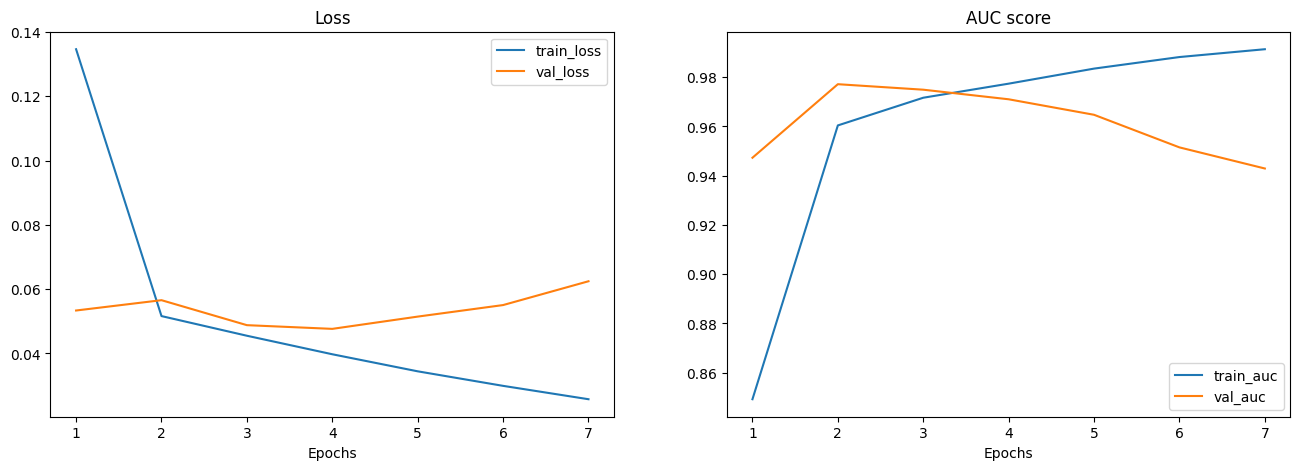

In [ ]:
# performance curve

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,8)]
ax[0].plot(epochs, bert_history.history['loss'], label = 'train_loss');
ax[0].plot(epochs, bert_history.history['val_loss'], label = 'val_loss');
ax[0].set_title("Loss");
ax[0].set_xlabel("Epochs")
ax[0].legend();

ax[1].plot(epochs, bert_history.history['auc'], label = 'train_auc');
ax[1].plot(epochs, bert_history.history['val_auc'], label = 'val_auc');
ax[1].set_title("AUC score");
ax[1].set_xlabel("Epochs")
ax[1].legend();


In [ ]:
! zip best_bert_model.zip best_bert_model -r

  adding: best_bert_model/ (stored 0%)
  adding: best_bert_model/variables/ (stored 0%)
  adding: best_bert_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: best_bert_model/variables/variables.index (deflated 75%)
  adding: best_bert_model/assets/ (stored 0%)
  adding: best_bert_model/assets/vocab.txt (deflated 53%)
  adding: best_bert_model/saved_model.pb (deflated 91%)
  adding: best_bert_model/keras_metadata.pb (deflated 85%)
  adding: best_bert_model/fingerprint.pb (stored 0%)


From the performance curve, we see that after 3 epochs, both loss and auc score for validation data does not improve, while for train data it still improves,showing overfitting problem. We had set the callback to stop the training to prevent overfitting and also save the model at the best iteration.

In [ ]:
# load the best model
bert_model = tf.keras.models.load_model('best_bert_model', compile = False)

In [ ]:
# compile the model
bert_model.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [ ]:
loss, accuracy,auc = bert_model.evaluate(test_ds)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


998/998 [==============================] - 118s 118ms/step - loss: 0.0476 - binary_accuracy: 0.9820 - auc: 0.9560


In [ ]:
import numpy as np

print(f"Accuracy: {np.round(accuracy,4)}")
print(f"AUC: {np.round(auc,4)}")
print(f"Logloss: {np.round(loss,4)}")

Accuracy: 0.982
AUC: 0.956
Logloss: 0.0476


With transfer learning using BERT model, we see we achieve better results , with improvements in Accuracy, AUC and LogLoss.